ADIM 1: Veriyi Yükleme ve İlk Bakış
"Veri seti ilk yüklendiğinde Fiyat ve Yorum Sayısı sütunlarının 'object' (metin) tipinde olduğu görüldü. Model eğitimi için bunların sayısal (float/int) tipe dönüştürülmesi gerekmektedir."

In [1]:
# Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Görselleştirme Ayarları
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Veriyi Yükle
try:
    df = pd.read_csv("tum_urunler.csv")
    print("✅ Veri Seti Başarıyla Yüklendi!")
except FileNotFoundError:
    print("❌ Hata: 'tum_urunler.csv' bulunamadı. Lütfen scraper.py'yi çalıştırın.")

# 2. İlk 5 Satırı Görelim
print("\n--- İlk 5 Satır ---")
print(df.head())

# 3. Veri Tiplerini ve Boş Değerleri İnceleyelim
print("\n--- Veri Özeti (Info) ---")
print(df.info())

print("\n--- Boş Değer Sayısı ---")
print(df.isnull().sum())

✅ Veri Seti Başarıyla Yüklendi!

--- İlk 5 Satır ---
  Kategori   Marka                                              Model  \
0   Laptop  Lenovo  Lenovo IdeaPad Slim 3 15IAN8 82XB009GTX N100 4...   
1   Laptop  Lenovo  Lenovo V15 G4 AMN 82YU0124TX R5-7520U 8 GB 512...   
2   Laptop  Lenovo  Lenovo V15 G4 AMN 82YU0123TX R5-7520U 16 GB 51...   
3   Laptop      HP  HP Victus 15-FB2003NT A05NGEA R7-8840H 16 GB 1...   
4   Laptop     MSI  MSI Cyborg 15 A13VE-1479XTR i7-13620H 16 GB 51...   

      Fiyat  Yorum_Sayisi                                               Link  
0   9399.00          19.0  https://www.n11.com/urun/lenovo-ideapad-slim-3...  
1  16894.52          73.0  https://www.n11.com/urun/lenovo-v15-g4-amn-82y...  
2  19799.00         411.0  https://www.n11.com/urun/lenovo-v15-g4-amn-82y...  
3  44637.78           0.0  https://www.n11.com/urun/hp-victus-15-fb2003nt...  
4  43499.00          10.0  https://www.n11.com/urun/msi-cyborg-15-a13ve-1...  

--- Veri Özeti (Info) ---
<class 

2. Adım Veri Temizleme ve Tip Dönüşümü
"Tutarsızlıkların Giderilmesi" ve "Veri Tipi Dönüşümü" adımıdır.

In [2]:
# --- Fiyat Temizliği ---
# "25.000 TL" -> 25000 (Sayı) haline getiriyoruz.
# Önce string yap, sonra TL ve noktaları sil, virgülü nokta yap.
def clean_price(price):
    if pd.isna(price): return None
    price = str(price)
    price = price.replace(" TL", "").replace("TL", "").replace(".", "").replace(",", ".")
    return float(price)

df['Fiyat'] = df['Fiyat'].apply(clean_price)

# --- Yorum Sayısı Temizliği ---
# "(55)" -> 55 (Sayı) haline getiriyoruz.
def clean_comments(comment):
    if pd.isna(comment): return 0
    comment = str(comment)
    comment = comment.replace("(", "").replace(")", "").replace(".", "")
    if comment == "": return 0
    return int(comment)

df['Yorum_Sayisi'] = df['Yorum_Sayisi'].apply(clean_comments)

# --- Eksik Verileri Doldurma ---
# Fiyatı boş olanları atalım (Fiyatı olmayan ürünle işimiz yok)
df.dropna(subset=['Fiyat'], inplace=True)

# Markası boş olanlara "Diğer" diyelim
df['Marka'].fillna("Diğer", inplace=True)

print("\n✅ Veri Tipleri Düeltildi:")
print(df.dtypes)


✅ Veri Tipleri Düeltildi:
Kategori         object
Marka            object
Model            object
Fiyat           float64
Yorum_Sayisi      int64
Link             object
dtype: object


/var/folders/x4/79sm3j81269dw8tmh4g9579w0000gn/T/ipykernel_17170/3622803969.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Marka'].fillna("Diğer", inplace=True)


ADIM 3: Aykırı Değer (Outlier) Analizi ve Temizliği
Örneğin, Laptop kategorisinde 500 TL'ye (kılıf olabilir) veya 1.000.000 TL'ye (aşırı pahalı sunucu) ürünler olabilir. Bunlar modelimizin kafasını karıştırır. Bunları IQR Yöntemi ile temizleyeceğiz.

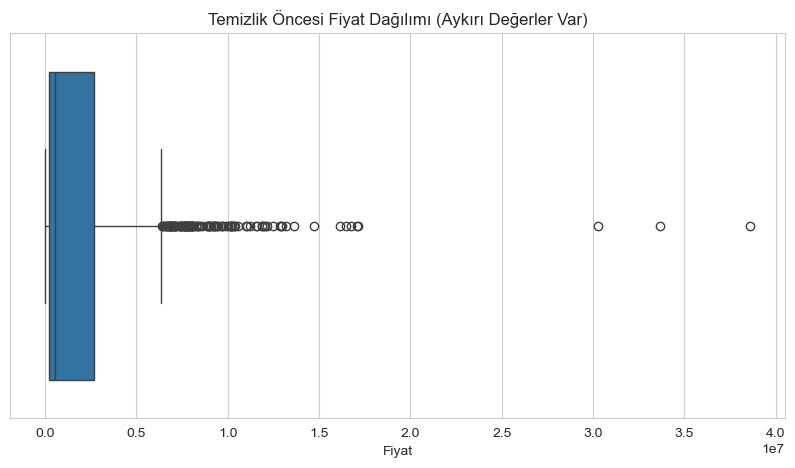

Alt Sınır: -3479857.0 TL | Üst Sınır: 6359735.0 TL

Temizlik Öncesi Veri Sayısı: 1329
Temizlik Sonrası Veri Sayısı: 1215
Silinen Aykırı Veri Sayısı: 114


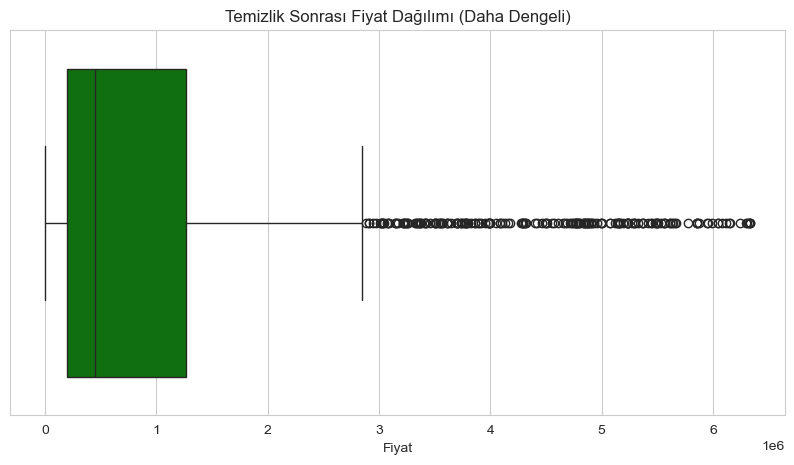

In [3]:
# --- Aykırı Değerleri Görelim (Boxplot) ---
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Fiyat'])
plt.title("Temizlik Öncesi Fiyat Dağılımı (Aykırı Değerler Var)")
plt.show()

# --- IQR Yöntemiyle Temizlik ---
# Çeyrekler Arası Aralık (IQR) hesaplanır.
Q1 = df['Fiyat'].quantile(0.25)
Q3 = df['Fiyat'].quantile(0.75)
IQR = Q3 - Q1

# Alt ve Üst Sınırlar
alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

print(f"Alt Sınır: {alt_sinir} TL | Üst Sınır: {ust_sinir} TL")

# Sınırların dışındaki verileri atalım
df_clean = df[(df['Fiyat'] > alt_sinir) & (df['Fiyat'] < ust_sinir)]

print(f"\nTemizlik Öncesi Veri Sayısı: {len(df)}")
print(f"Temizlik Sonrası Veri Sayısı: {len(df_clean)}")
print(f"Silinen Aykırı Veri Sayısı: {len(df) - len(df_clean)}")

# --- Temizlenmiş Grafiği Çizelim ---
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_clean['Fiyat'], color='green')
plt.title("Temizlik Sonrası Fiyat Dağılımı (Daha Dengeli)")
plt.show()

"Fiyat değişkenindeki aşırı uç değerler (Outliers), IQR yöntemi kullanılarak tespit edilmiş ve veri setinden çıkarılmıştır. Bu işlem, modelin genel geçerliliğini artırmak ve aşırı öğrenmeyi (Overfitting) engellemek için yapılmıştır."

ADIM 4: Detaylı Görselleştirme (EDA)

/var/folders/x4/79sm3j81269dw8tmh4g9579w0000gn/T/ipykernel_17170/1937770973.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kategori', y='Fiyat', data=df_clean, estimator=np.mean, palette='viridis', errorbar=None)


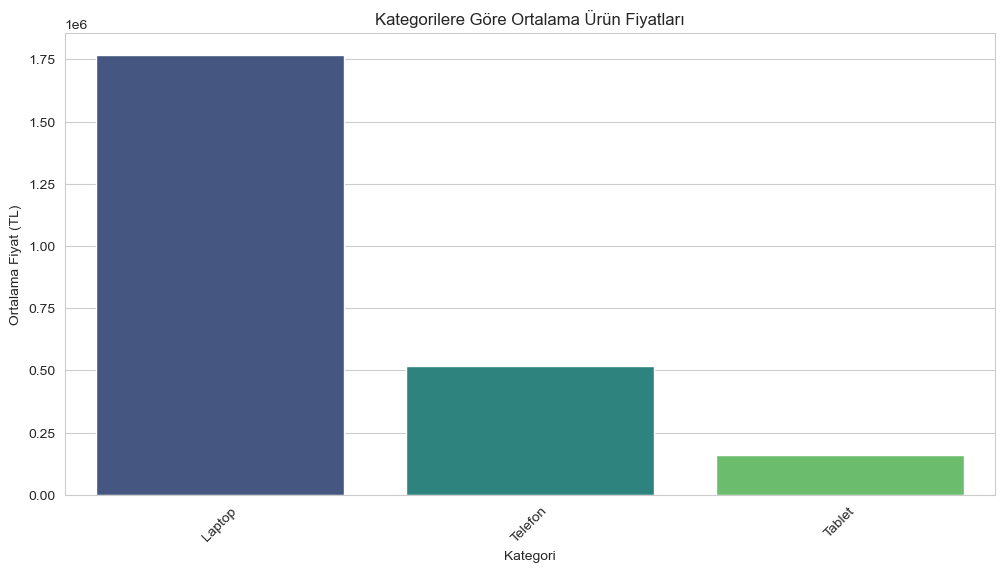

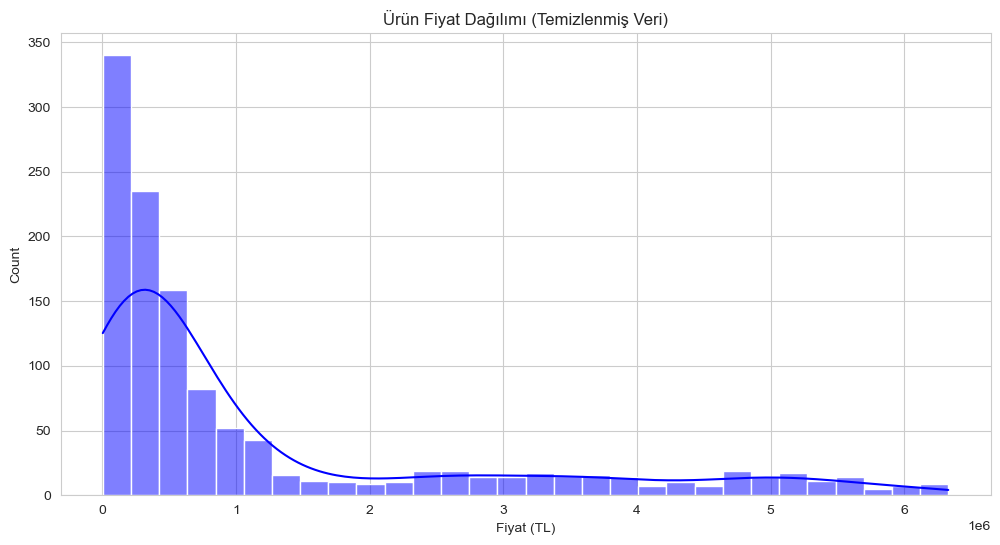

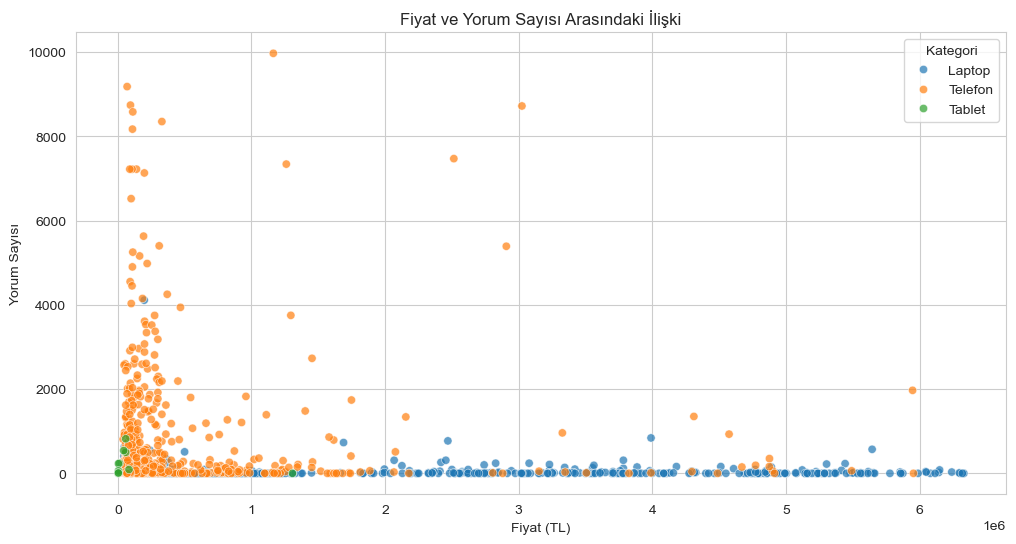

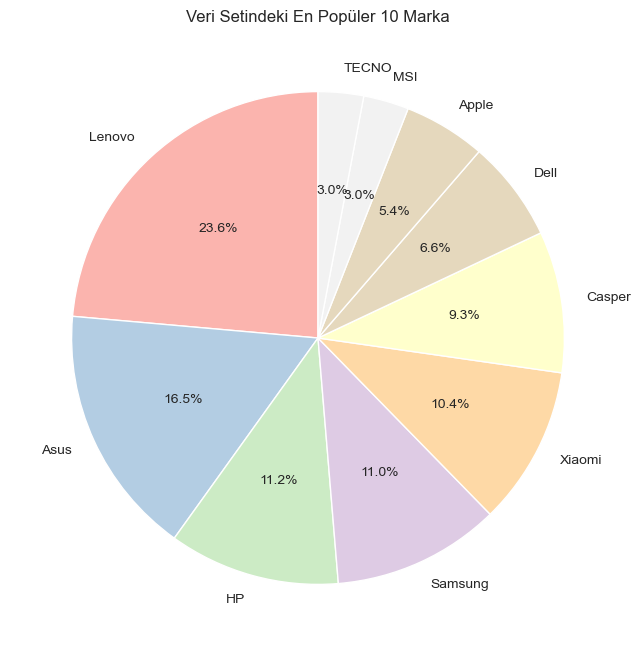

In [4]:
# --- ADIM 4: Detaylı Görselleştirme ---

# 1. Kategorilere Göre Ortalama Fiyat (Bar Chart)
plt.figure(figsize=(12, 6))
sns.barplot(x='Kategori', y='Fiyat', data=df_clean, estimator=np.mean, palette='viridis', errorbar=None)
plt.title("Kategorilere Göre Ortalama Ürün Fiyatları")
plt.xticks(rotation=45)
plt.ylabel("Ortalama Fiyat (TL)")
plt.show()

# 2. Fiyat Dağılımı (Histogram)
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['Fiyat'], bins=30, kde=True, color='blue')
plt.title("Ürün Fiyat Dağılımı (Temizlenmiş Veri)")
plt.xlabel("Fiyat (TL)")
plt.show()

# 3. Fiyat ve Yorum Sayısı İlişkisi (Scatter Plot)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Fiyat', y='Yorum_Sayisi', data=df_clean, hue='Kategori', alpha=0.7)
plt.title("Fiyat ve Yorum Sayısı Arasındaki İlişki")
plt.xlabel("Fiyat (TL)")
plt.ylabel("Yorum Sayısı")
plt.show()

# 4. Marka Dağılımı (Pie Chart - İlk 10 Marka)
plt.figure(figsize=(8, 8))
df_clean['Marka'].value_counts().head(10).plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
plt.title("Veri Setindeki En Popüler 10 Marka")
plt.ylabel("")
plt.show()

Temiz veri setini kaydetme. 

In [5]:
df_clean.to_csv("cleaned_data.csv", index=False)
print("✅ EDA Tamamlandı! Temiz veri 'cleaned_data.csv' olarak kaydedildi.")
print(f"Son Veri Sayısı: {len(df_clean)}")

✅ EDA Tamamlandı! Temiz veri 'cleaned_data.csv' olarak kaydedildi.
Son Veri Sayısı: 1215
